In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
plt.style.use('seaborn')
%matplotlib inline

In [4]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
default_dir = "/content/gdrive/My Drive"
app_train = pd.read_csv(os.path.join(default_dir, 'FIFA_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir, 'FIFA_test.csv'))
fifa = pd.read_csv(os.path.join(default_dir, 'fifa.csv'))

def get_apps_dataset():
    default_dir = "/content/gdrive/My Drive"
    app_train = pd.read_csv(os.path.join(default_dir, 'FIFA_train.csv'))
    app_test = pd.read_csv(os.path.join(default_dir, 'FIFA_test.csv'))
    apps = pd.concat([app_train, app_test])
    
    return apps, app_train, app_test, fifa


In [6]:
(apps, train, test, fifa) = get_apps_dataset()

In [ ]:
fifa.info()
# continent, position, prefer_foot, contract_until 은 명목변수 / 더미변수화 예정
# reputation, stat_skill_moves는 순위변수처럼 보이는데 연속형변수로 생각하고 적합할지, 더미변수로 적합해야 하는지 논의 필요
# id, name 과 같은 변수는 제거 예정
# 결측치는 보이지 않음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8932 non-null   int64 
 1   name              8932 non-null   object
 2   age               8932 non-null   int64 
 3   continent         8932 non-null   object
 4   contract_until    8932 non-null   int64 
 5   position          8932 non-null   object
 6   prefer_foot       8932 non-null   object
 7   reputation        8932 non-null   int64 
 8   stat_overall      8932 non-null   int64 
 9   stat_potential    8932 non-null   int64 
 10  stat_skill_moves  8932 non-null   int64 
 11  value             8932 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 837.5+ KB


In [ ]:
# 범주형 변수들에 대해서 각각 가지는 unique 값 확인
name = ['continent', 'position', 'prefer_foot', 'reputation', 'stat_skill_moves', 'contract_until']
for i in name:
  print('{}:'.format(i), fifa[i].unique(), '\n')


continent: ['south america' 'europe' 'africa' 'asia' 'oceania'] 

position: ['ST' 'GK' 'MF' 'DF'] 

prefer_foot: ['left' 'right'] 

reputation: [5 3 4 2 1] 

stat_skill_moves: [4 3 1 5 2] 

contract_until: [2021 2022 2020 2023 2019 2024 2026 2018 2025] 



In [ ]:
# 범주형 변수들의 unique한 값들이 어떻게 분포되어 있는지 확인
name = ['continent', 'position', 'prefer_foot', 'reputation', 'stat_skill_moves','contract_until']

for i in name:
  print(fifa.loc[:, i].value_counts(), '\n')

europe           5322
south america    1927
asia              787
africa            721
oceania           175
Name: continent, dtype: int64 

MF    3428
DF    2791
ST    1705
GK    1008
Name: position, dtype: int64 

right    6837
left     2095
Name: prefer_foot, dtype: int64 

1    8014
2     706
3     177
4      31
5       4
Name: reputation, dtype: int64 

2    3905
3    3473
1    1008
4     515
5      31
Name: stat_skill_moves, dtype: int64 

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64 



In [ ]:
# 위의 범주형 변수들을 제외하고 나머지 변수들에 대해 기초통계량 확인
fifa[['age','stat_overall','stat_potential','value']].describe()

# value변수의 mean이 제 3사분위수 보다 큰 값으로 데이터가 right-skewed
# value변수에 대해서는 log변환이나 Box-Cox변환이 필요해 보임

,age,stat_overall,stat_potential,value
count,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,25.209136,67.091133,71.997201,2.778673e+06
std,4.635515,6.854910,5.988147,5.840982e+06
min,16.000000,47.000000,48.000000,1.000000e+04
25%,21.000000,63.000000,68.000000,3.750000e+05
50%,25.000000,67.000000,72.000000,8.250000e+05
75%,28.000000,72.000000,76.000000,2.600000e+06
max,40.000000,94.000000,94.000000,1.105000e+08


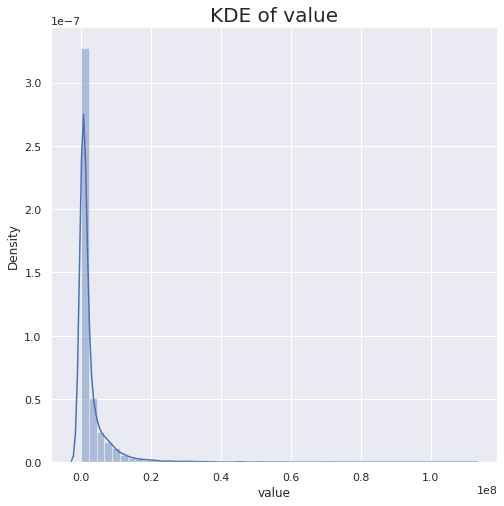

In [ ]:
# value변수에 대한 커널밀도추정으로 분포를 확인
a = fifa['value']
plt.figure(figsize=(8,8))
ax = sns.distplot(a)
ax.set_title('KDE of value', size=20)
plt.show()

In [ ]:
# id, name 변수 제거 후, 잘 제거되었는지 확인
data = fifa.drop(['id', 'name'], axis=1)
data.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5,94,94,4,110500000
1,31,south america,2021,ST,right,5,91,91,3,80000000
2,26,europe,2022,ST,right,3,88,91,4,73500000
3,27,europe,2020,GK,right,4,91,93,1,72000000
4,26,africa,2023,MF,left,3,88,89,4,69500000


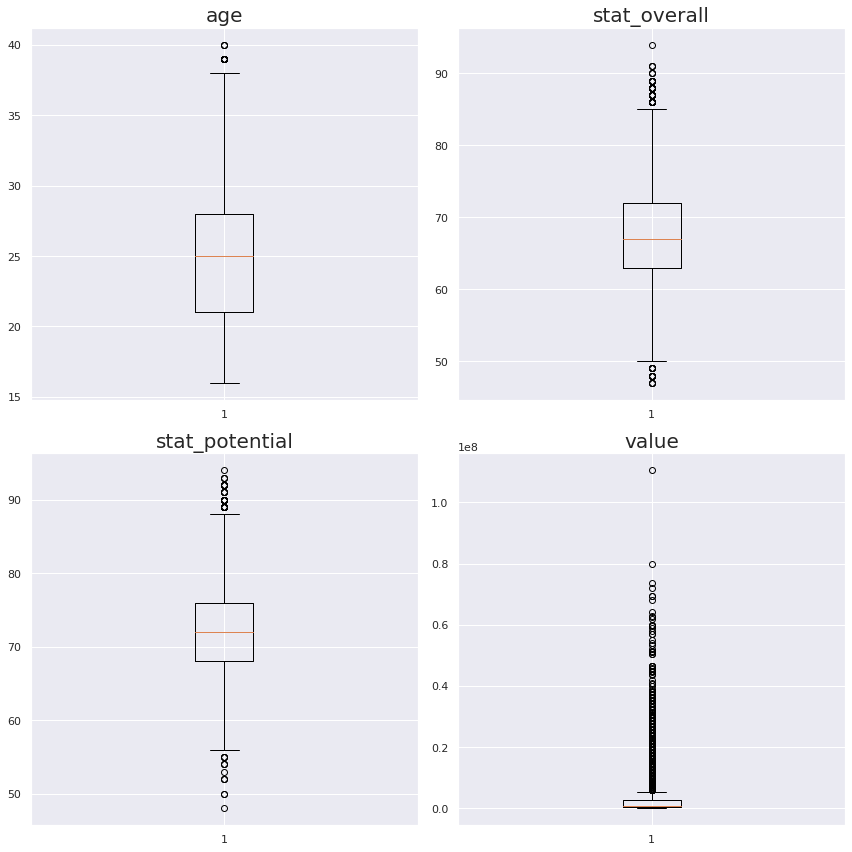

In [ ]:
# 연속형변수들에 대해 box-plot으로 outliers로 의심되는 값들 확인

b = ['age','stat_overall','stat_potential','value']
fig, axes = plt.subplots(2,2, figsize=(12,12))
for idx, ax in enumerate(axes.flat):
  ax.boxplot(data[b[idx]])
  ax.set_title(b[idx], size=20)
fig.tight_layout()

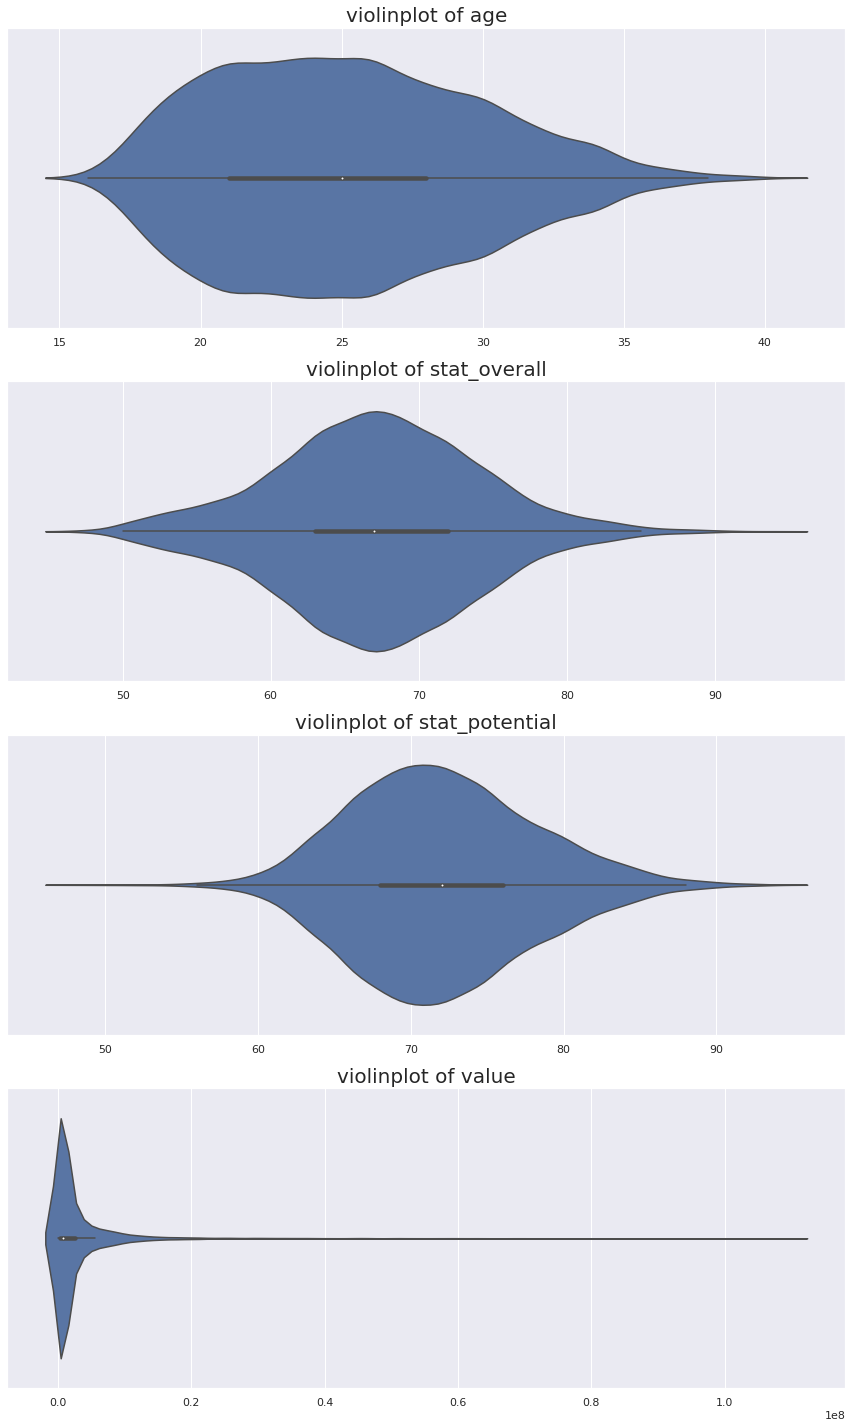

In [ ]:
# 위의 boxplot의 단점을 보완한 violinplot

ft_name = ['age', 'stat_overall', 'stat_potential', 'value' ]
sns.set(rc = {'figure.figsize':(12,20)})
fig, axs = plt.subplots(nrows = 4, ncols=1)
axs = axs.flat
for i,name in enumerate(ft_name):
  a = sns.violinplot(x=name, data=data, ax=axs[i])
  a.set_title('violinplot of {}'.format(name), fontsize=20)
  a.set_xlabel("")
fig.tight_layout()

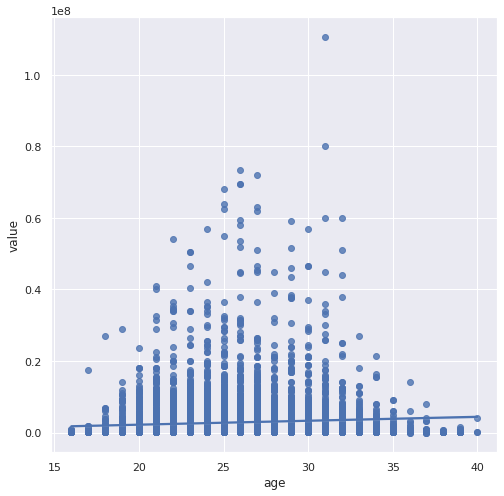

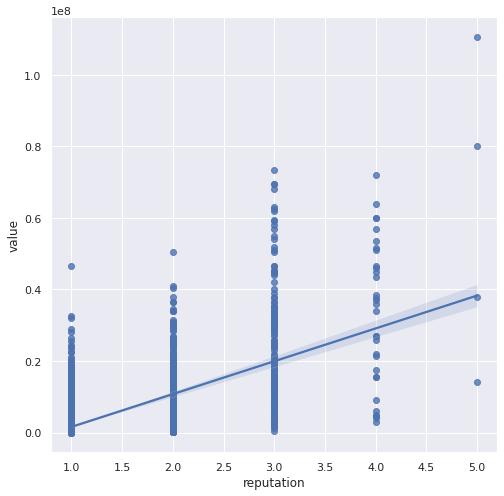

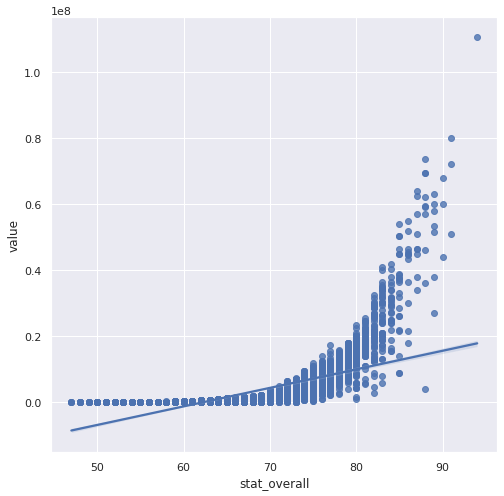

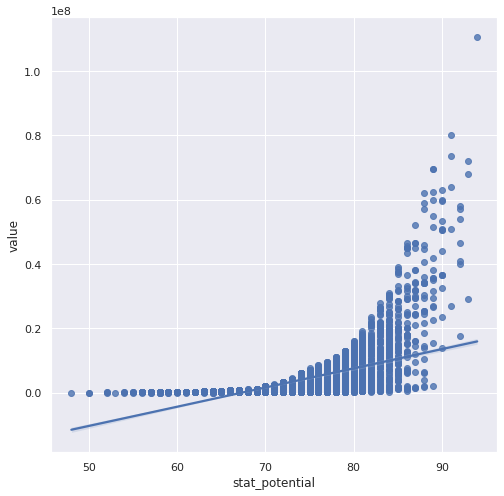

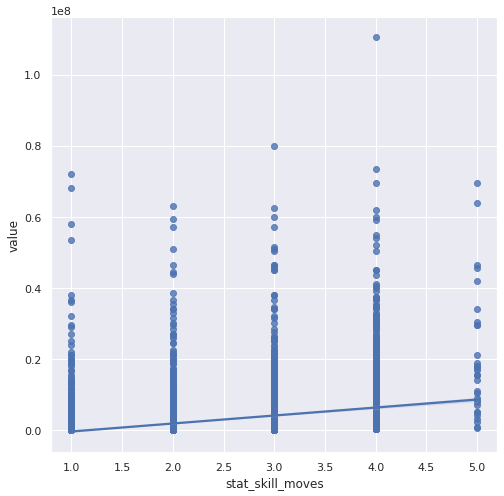

In [ ]:
# 종속변수 value와 다음의 변수들이 어떠한 선형관계가 있는지를 시각적으로 확안
ft_name = ['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']
sns.set(rc = {'figure.figsize':(8,8)})

for i, ft in enumerate(ft_name):
  sns.regplot(x=ft, y='value', data=data)
  plt.show()
  print('\n')

In [ ]:
# 변수간 상관관계 

corr_df = data[['stat_overall','stat_potential','value', 'stat_skill_moves', 'reputation']].corr()
corr_df

,stat_overall,stat_potential,value,stat_skill_moves,reputation
stat_overall,1.000000,0.665453,0.658444,0.400164,0.521389
stat_potential,0.665453,1.000000,0.611907,0.332578,0.399183
value,0.658444,0.611907,1.000000,0.298500,0.665982
stat_skill_moves,0.400164,0.332578,0.298500,1.000000,0.196582
reputation,0.521389,0.399183,0.665982,0.196582,1.000000


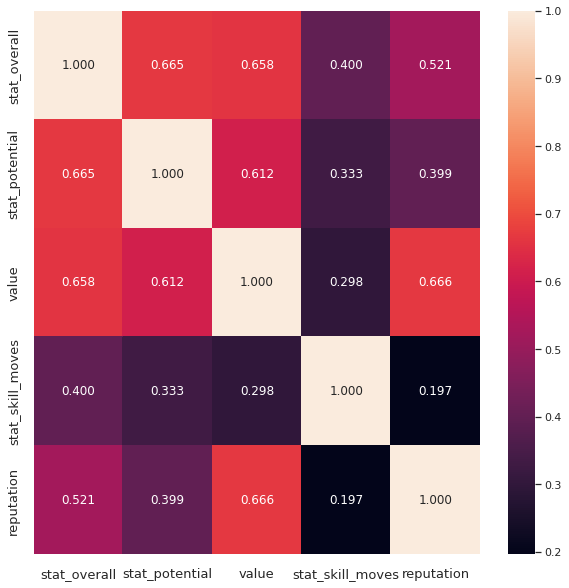

In [ ]:
# 변수간 상관관계  시각화

plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_df, annot=True, fmt='.3f')
ax.tick_params(labelsize=13, length=10, width=3)
plt.show()

In [ ]:
a = data[data['contract_until'] == 2024].replace(2024, '2024~')
b = data[data['contract_until'] == 2025].replace(2025, '2024~')
c = data[data['contract_until'] == 2026].replace(2026, '2024~')
d = pd.concat([a,b,c])

copy = data.copy()

copy[(copy['contract_until'] ==2024) | (copy['contract_until'] ==2025)  | (copy['contract_until'] ==2026)] = d

copy.contract_until.unique()

In [ ]:
copy.contract_until.astype('object')

0       2021
1       2021
2       2022
3       2020
4       2023
        ... 
8927    2021
8928    2021
8929    2021
8930    2018
8931    2018
Name: contract_until, Length: 8932, dtype: object

In [ ]:
# 'continent', 'position', 'prefer_foot', 'reputation','stat_skill_moves' 에 대해 더미변수화
name = ['continent', 'position', 'prefer_foot','contract_until']
dummies = pd.get_dummies(copy[name], drop_first=True)
fifa = pd.concat([copy, dummies], axis=1).drop(name, axis=1)
final_df = pd.get_dummies(fifa, columns=['reputation','stat_skill_moves'], drop_first=True)

In [ ]:
# 각각의 범주의 수에 맞게 더미변수화 된 것을 확인할 수 있음
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      8932 non-null   int64
 1   stat_overall             8932 non-null   int64
 2   stat_potential           8932 non-null   int64
 3   value                    8932 non-null   int64
 4   continent_asia           8932 non-null   uint8
 5   continent_europe         8932 non-null   uint8
 6   continent_oceania        8932 non-null   uint8
 7   continent_south america  8932 non-null   uint8
 8   position_GK              8932 non-null   uint8
 9   position_MF              8932 non-null   uint8
 10  position_ST              8932 non-null   uint8
 11  prefer_foot_right        8932 non-null   uint8
 12  contract_until_2019      8932 non-null   uint8
 13  contract_until_2020      8932 non-null   uint8
 14  contract_until_2021      8932 non-null   uint8
 15  cont

In [ ]:
# apps.to_csv('FIFA.csv')